Lab 12: Sentiment Analysis using Keras LSTM

In [1]:
!pip install tensorflow pandas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences


Load IMDB Dataset for Training

In [2]:
# Load top 10,000 most common words
num_words = 10000
max_len = 300

(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=num_words)
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)


17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Build and Train the LSTM Model


In [3]:
model = Sequential()
model.add(Embedding(input_dim=num_words, output_dim=128))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train for 2 epochs
model.fit(X_train, y_train, batch_size=64, epochs=2, validation_split=0.2)


Epoch 1/2
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.6696 - loss: 0.5922 - val_accuracy: 0.8418 - val_loss: 0.3606
Epoch 2/2
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.8898 - loss: 0.2737 - val_accuracy: 0.8634 - val_loss: 0.3242


Upload and Load Your Chatbot Data

In [4]:
from google.colab import files
uploaded = files.upload()


Saving chatbot_data.tsv to chatbot_data.tsv


In [5]:
df = pd.read_csv("chatbot_data.tsv", sep="\t")
df.head()


,user,agent
0,how do i change my flight date?,you can change your flight date by logging int...
1,what is the baggage allowance for internationa...,the baggage allowance for international flight...
2,my flight was canceled. what should i do?,we apologize for the inconvenience. please con...
3,can i upgrade my seat?,"yes, you can upgrade your seat by visiting our..."
4,how do i check in online?,you can check in online 24 hours before your f...


Prepare Word Index & Encoding Function


In [6]:
word_index = imdb.get_word_index()
word_index = {k: (v+3) for k, v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2
word_index["<UNUSED>"] = 3

def encode_chat_message(text, word_index, max_len=300, vocab_size=10000):
    tokens = text_to_word_sequence(text)
    encoded = [
        word_index.get(word, 2)
        for word in tokens
        if word_index.get(word, 2) < vocab_size
    ]
    return pad_sequences([encoded], maxlen=max_len)


1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 1s 1us/step


 Predict Sentiment on Chatbot Messages

In [8]:
# Tokenize all user messages
encoded_all = []
for text in df['user']:
    tokens = text_to_word_sequence(text)
    encoded = [
        word_index.get(word, 2)
        for word in tokens
        if word_index.get(word, 2) < num_words
    ]
    encoded_all.append(encoded)

# Pad all sequences at once
X_chatbot = pad_sequences(encoded_all, maxlen=max_len)

# Batch predict all at once
scores = model.predict(X_chatbot, verbose=0).flatten()

# Add results
df['LSTM_sentiment_score'] = scores

def score_to_label(score):
    if score >= 0.6:
        return "Positive"
    elif score <= 0.4:
        return "Negative"
    else:
        return "Neutral"

df['LSTM_label'] = df['LSTM_sentiment_score'].apply(score_to_label)


In [9]:
df[['user', 'LSTM_sentiment_score', 'LSTM_label']].head(10)


,user,LSTM_sentiment_score,LSTM_label
0,how do i change my flight date?,0.862468,Positive
1,what is the baggage allowance for internationa...,0.788796,Positive
2,my flight was canceled. what should i do?,0.818791,Positive
3,can i upgrade my seat?,0.899434,Positive
4,how do i check in online?,0.909429,Positive
5,how do i check my flight status?,0.868044,Positive
6,what is the carry-on baggage allowance?,0.638993,Positive
7,i missed my connecting flight. what can i do?,0.830673,Positive
8,can i add extra baggage to my booking?,0.807208,Positive
9,how can i request a special meal for my flight?,0.962820,Positive


Visualize LSTM Output

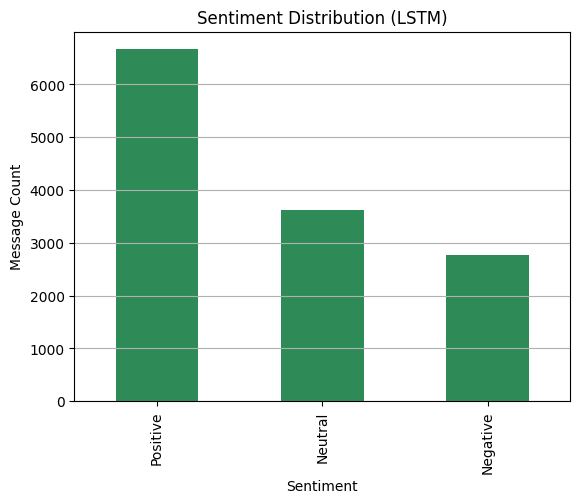

In [10]:
sentiment_counts = df['LSTM_label'].value_counts()
sentiment_counts.plot(kind='bar', color='seagreen')
plt.title("Sentiment Distribution (LSTM)")
plt.xlabel("Sentiment")
plt.ylabel("Message Count")
plt.grid(axis='y')
plt.show()


In [11]:
df[['user', 'LSTM_sentiment_score', 'LSTM_label']].to_csv('lstm_predictions.csv', index=False)


In [13]:
# Sample training set
train_texts = [
    "I love this!", "That was amazing.", "This is great.",
    "I hate it.", "This is terrible.", "Awful experience.",
    "It's okay.", "Not bad.", "Could be better.",
    "I'm very happy.", "I'm very disappointed."
]
train_labels = ["pos", "pos", "pos", "neg", "neg", "neg", "neu", "neu", "neu", "pos", "neg"]

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_texts)

model_ml = LinearSVC()
model_ml.fit(X_train, train_labels)

# Apply on chatbot user messages
X_test = vectorizer.transform(df['user'].astype(str))
df['ML_sentiment'] = model_ml.predict(X_test)


In [15]:
!pip install textblob
!python -m textblob.download_corpora


[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.


In [16]:
from textblob import TextBlob

def get_textblob_sentiment(text):
    polarity = TextBlob(str(text)).sentiment.polarity
    if polarity > 0:
        return "Positive"
    elif polarity < 0:
        return "Negative"
    else:
        return "Neutral"

df['TextBlob_sentiment'] = df['user'].apply(get_textblob_sentiment)


 FINAL COMPARISON VISUALIZATION CODE

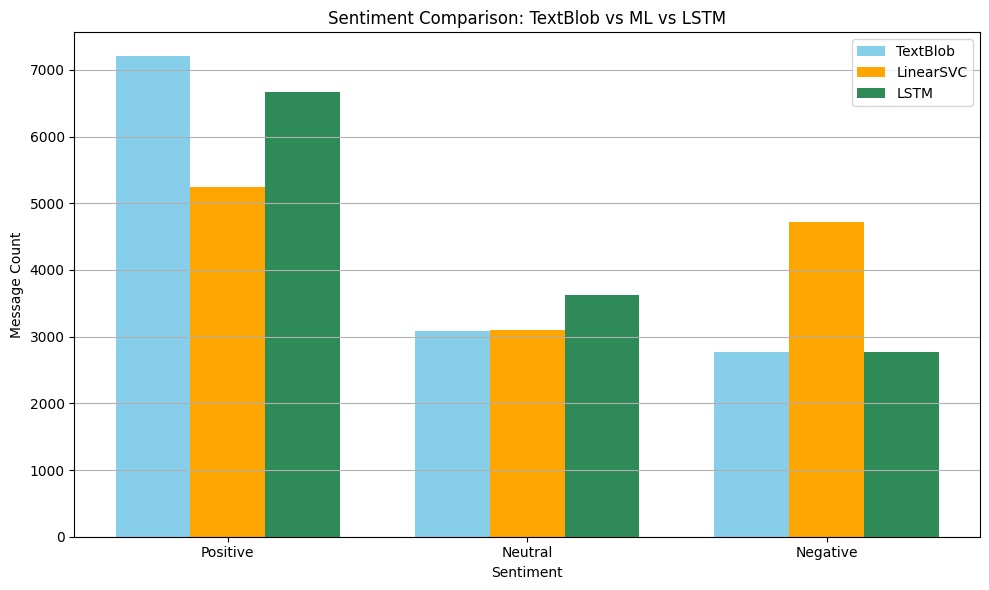

In [17]:
ml_map = {'pos': 'Positive', 'neg': 'Negative', 'neu': 'Neutral'}
df['ML_label'] = df['ML_sentiment'].map(ml_map)

labels = ['Positive', 'Neutral', 'Negative']

blob_counts = df['TextBlob_sentiment'].value_counts()
ml_counts = df['ML_label'].value_counts()
lstm_counts = df['LSTM_label'].value_counts()

blob_vals = [blob_counts.get(label, 0) for label in labels]
ml_vals = [ml_counts.get(label, 0) for label in labels]
lstm_vals = [lstm_counts.get(label, 0) for label in labels]

import matplotlib.pyplot as plt

x = range(len(labels))
bar_width = 0.25

plt.figure(figsize=(10, 6))
plt.bar(x, blob_vals, width=bar_width, label='TextBlob', color='skyblue')
plt.bar([i + bar_width for i in x], ml_vals, width=bar_width, label='LinearSVC', color='orange')
plt.bar([i + 2*bar_width for i in x], lstm_vals, width=bar_width, label='LSTM', color='seagreen')

plt.xlabel('Sentiment')
plt.ylabel('Message Count')
plt.title('Sentiment Comparison: TextBlob vs ML vs LSTM')
plt.xticks([i + bar_width for i in x], labels)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()
